In [1301]:
import os
import torch
import json
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')

from pandas.plotting import scatter_matrix
from scipy.spatial import distance
from scipy.stats import percentileofscore



The aim of this notebook is to look at the position of a nearest neighbour in another latent space (constructed with the same data):

- take a vector idx in a latent space A and find its nearest neighbour (nn)
- calculate the distance between idx and nn in a latent space B. (B is supposed to contain the representation of the same elements than in A.)
- rank nn in terms of distance to idx in B (it is first if it is still the closest to idx in B and last if it is the furthest)
- do stats on that

This is a proxy to see if the structure of a latent space is conserved from one to another (a couple of points that are close in a latent space souldn't be too far in the other one).

To use this notebook, you have to set up the paths to the csv files in the next code cell, then you can just Run All.

# Load the data

In [1302]:
def load_embeddings(path1, path2, verbose=False):    
    # load embeddings
    embeddings1 = pd.read_csv(path1, index_col=0)
    embeddings2 = pd.read_csv(path2, index_col=0)

    if verbose:
        print(embeddings1.head())
        print(embeddings2.head())

        print((embeddings1.index == embeddings2.index).all())

    return embeddings1, embeddings2

# choose models by hand
#dir_path = "/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders/pca/4"
#path1 = dir_path + "/Run1/pca_embeddings.csv"
#path2 = dir_path + "/Run2/pca_embeddings.csv"

# choose random models with same conditions
def choose_random_models(dir_path):
    list_models = [file for file in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path,file))]
    mod1, mod2 = rd.choice(list_models, size=2, replace=False)
    mod1, mod2 = np.sort([mod1, mod2])
    print("chosen_models", mod1, mod2)
    return mod1, mod2


dir_path = "/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders"
model_type = 'densenet2'
conditions = 'no_foldlabel_30'
full_dir_path = os.path.join(dir_path, model_type, conditions)


mod1, mod2 = choose_random_models(full_dir_path)


## store the graphs and values (or not)
#save_path = None

save_path = os.path.join(dir_path, "performance_comparisons/nn", model_type+'_'+conditions)
if not os.path.exists(save_path):
    os.mkdir(save_path)


# don't do twice the same thing
if save_path:
    while os.path.exists(os.path.join(save_path, mod1+'_'+mod2+".png")):
        mod1, mod2 = choose_random_models(full_dir_path)


path1 = os.path.join(full_dir_path, mod1, "cingulate_ACCpatterns_embeddings/full_embeddings.csv")
path2 = os.path.join(full_dir_path, mod2, "cingulate_ACCpatterns_embeddings/full_embeddings.csv")


embeddings1, embeddings2 = load_embeddings(path1, path2, verbose=True)

if embeddings1.shape[1] != embeddings2.shape[1]:
    raise ValueError("The two chosen embeddings haven't the same dimensions.")

n_dims = embeddings1.shape[1]
print(n_dims)

chosen_models 09-15-52 11-40-43
                  dim1       dim2       dim3      dim4       dim5       dim6  \
ID                                                                             
1-15LEHMI_t0 -0.004444  25.558067  -7.017207 -0.000010  12.471397   4.953064   
1-17COLMA_t0 -0.005315  13.271053  -8.473522 -0.000012  18.429623   3.457779   
1-18ROUCO_t0 -0.008934  19.763634  -6.842281 -0.000020  11.298117  12.213625   
1-40AYMJU_t0 -0.009937  10.699167 -10.362768 -0.000014  16.483280 -32.625504   
2-02FERMA_t0 -0.007631  -2.992713  -6.595952 -0.000017  10.300482  -6.464139   

                  dim7      dim8       dim9      dim10  ...     dim21  \
ID                                                      ...             
1-15LEHMI_t0 -0.000008 -2.146704  -6.766045 -24.435528  ... -1.567969   
1-17COLMA_t0 -0.000009 -2.872793 -10.730208 -26.571823  ... -2.017656   
1-18ROUCO_t0 -0.000005 -1.880878  -6.879739 -16.115072  ... -1.167536   
1-40AYMJU_t0 -0.000020 -5.243915 -16.72210

# Plot the scatter matrices of the two df

Only the four first dimensions

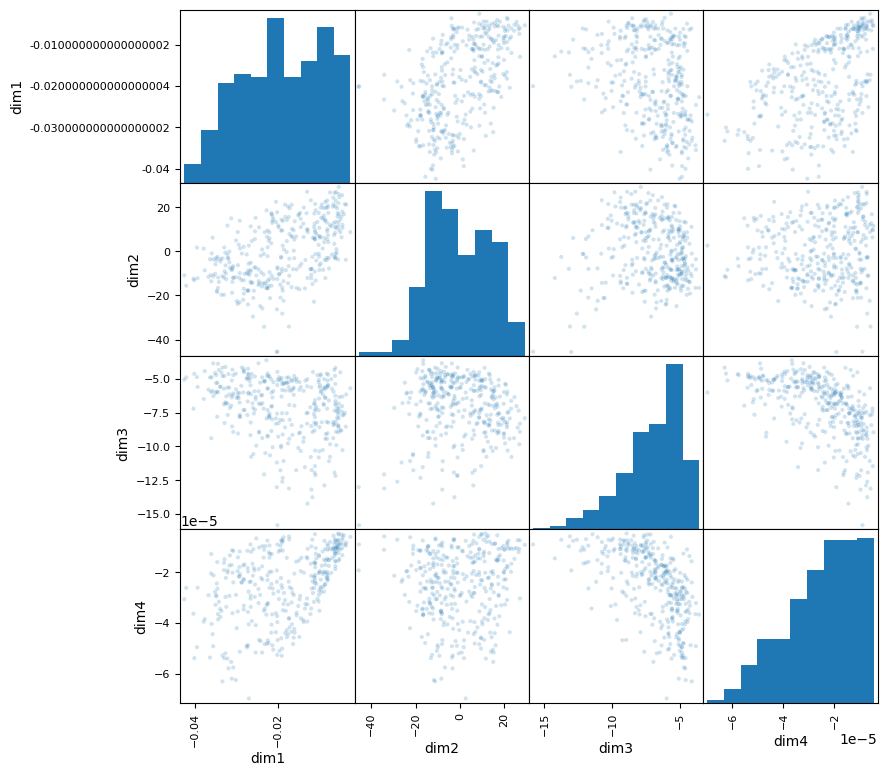

In [1303]:
sm1 = scatter_matrix(embeddings1[["dim1", "dim2", "dim3", "dim4"]], alpha=0.2, figsize=(9,9))

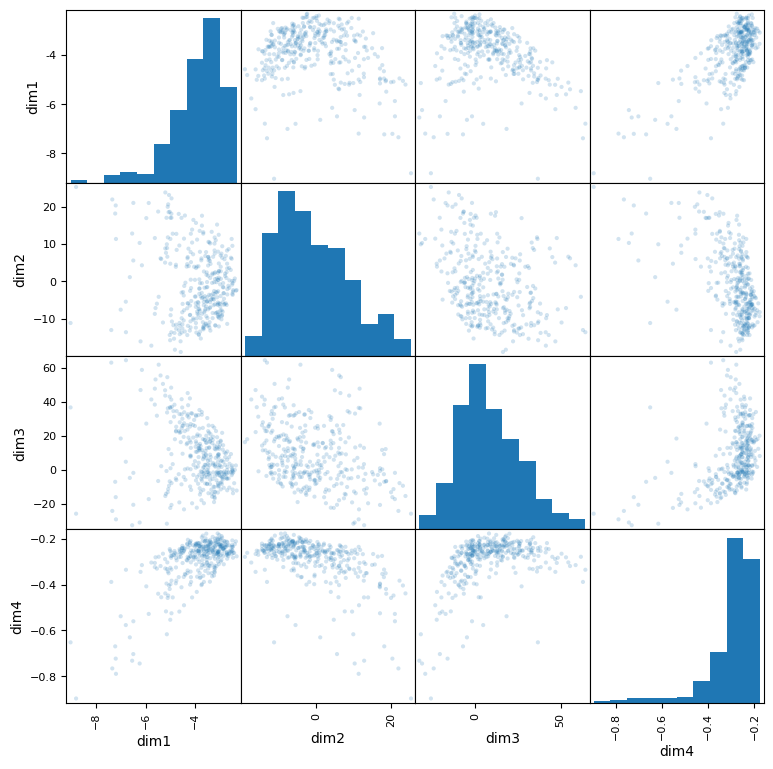

In [1304]:
sm2 = scatter_matrix(embeddings2[["dim1", "dim2", "dim3", "dim4"]], alpha=0.2, figsize=(9,9))

# Get the nearest neighbour

In [1305]:
# tests distance.euclidian
"""line1 = embeddings1.iloc[1,:]
line2 = embeddings1.iloc[2,:]
print(line1)
print(line2)

print(distance.euclidean(line1, line2))

embeddings1.apply(distance.euclidean, axis=1, args=[np.array(line1)])"""

'line1 = embeddings1.iloc[1,:]\nline2 = embeddings1.iloc[2,:]\nprint(line1)\nprint(line2)\n\nprint(distance.euclidean(line1, line2))\n\nembeddings1.apply(distance.euclidean, axis=1, args=[np.array(line1)])'

In [1306]:
# get the nearest neighbour of a line of the dataset df
# returns the label of the nn and its distance to the line
def get_nearest_neighbour(line, df, dist=distance.euclidean):
    idx = line.name
    df_without_line = df[df.index != idx]
    distances = df_without_line.apply(dist, axis=1, args=[np.array(line)]).to_frame()
    nn = distances.idxmin()[0]
    min_dist = distances[0][nn]
    return [nn, min_dist]

In [1307]:
# test the function
"""get_nearest_neighbour(line1, embeddings1)"""

'get_nearest_neighbour(line1, embeddings1)'

In [1308]:
# get the nearest neighbours and their distance for the first run

nearest_neighbours1 = embeddings1.apply(get_nearest_neighbour, axis=1, result_type='expand', 
                                          args=[embeddings1])
embeddings1['nn'] = nearest_neighbours1[0]
embeddings1['min_dist'] = nearest_neighbours1[1]
embeddings1

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,nn,min_dist
ID,,,,,,,,,,,,,,,,,,,,,
1-15LEHMI_t0,-0.004444,25.558067,-7.017207,-0.000010,12.471397,4.953064,-8.165154e-06,-2.146704,-6.766045,-24.435528,...,15.222837,6.738091,-0.334676,-0.358422,-0.009466,-0.806240,13.317281,8.172756,a0013_t1_s03,9.008756
1-17COLMA_t0,-0.005315,13.271053,-8.473522,-0.000012,18.429623,3.457779,-9.076142e-06,-2.872793,-10.730208,-26.571823,...,5.021764,15.294966,-0.267425,-0.370499,-0.012727,-1.454485,22.035570,10.022554,a0008_t1_s03,17.391015
1-18ROUCO_t0,-0.008934,19.763634,-6.842281,-0.000020,11.298117,12.213625,-4.654179e-06,-1.880878,-6.879739,-16.115072,...,16.617538,6.827261,-0.273070,-0.380859,-0.005844,-1.005918,3.270971,5.680888,e0039_t1_s03,9.720046
1-40AYMJU_t0,-0.009937,10.699167,-10.362768,-0.000014,16.483280,-32.625504,-1.972877e-05,-5.243915,-16.722107,-26.567757,...,38.257880,17.044110,-0.684084,-0.654528,-0.025628,-2.208143,29.089916,37.416206,2-29PIEMA_t0,16.325182
2-02FERMA_t0,-0.007631,-2.992713,-6.595952,-0.000017,10.300482,-6.464139,-6.727129e-06,-4.031458,-13.397495,-1.695438,...,30.765263,12.538214,-0.516831,-0.854151,-0.009948,-1.110439,0.748486,30.409298,sub-inhibition15_ses-pretraining_T1w,17.079091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-inhibition10_ses-pretraining_T1w,-0.017764,4.690929,-7.547219,-0.000014,7.567826,22.152588,-3.551061e-07,-2.413488,-10.235022,4.213577,...,13.222297,4.733101,-0.231930,-0.429575,-0.002124,-1.089905,-8.957533,8.694870,nih_chp_04266_t1,12.259075
sub-inhibition14_ses-pretraining_T1w,-0.027129,-24.093472,-6.081417,-0.000020,23.708850,21.869884,-1.215928e-07,-3.336918,-13.716052,47.180634,...,19.197514,4.417011,-0.356046,-0.441018,-0.002509,-2.446392,-30.581127,6.979282,nih_chp_01094_t1,10.524117
sub-inhibition23_ses-pretraining_T1w,-0.006039,-1.084396,-12.186533,-0.000010,30.005783,-18.625729,-1.708228e-05,-4.732337,-17.611671,-31.377787,...,12.621368,22.522104,-0.338269,-0.496571,-0.023846,-2.463750,39.455223,22.282036,a0039_t1_s03,29.810325


In [1309]:
# get the nearest neighbours and their distance for the second run

nearest_neighbours2 = embeddings2.apply(get_nearest_neighbour, axis=1, result_type='expand',
                                          args=[embeddings2])
embeddings2['nn'] = nearest_neighbours2[0]
embeddings2['min_dist'] = nearest_neighbours2[1]
embeddings2

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,nn,min_dist
ID,,,,,,,,,,,,,,,,,,,,,
1-15LEHMI_t0,-3.162792,11.025247,6.990847,-0.265853,16.383474,-0.184601,7.482101,-0.150981,6.135046,12.050046,...,-2.451342,-6.773812,1.464920,17.669325,6.219358,-0.137643,-1.067937,1.896240,sub-active15_ses-pretraining_T1w,12.779121
1-17COLMA_t0,-3.206880,11.761819,14.200977,-0.248559,13.256817,-0.209179,5.977326,-0.137069,11.251799,6.916715,...,-2.096711,-6.423316,-3.647946,15.783958,2.728678,-0.152511,-1.017849,4.224224,nih_chp_04220_t1,13.519742
1-18ROUCO_t0,-2.702886,4.756844,5.889623,-0.265607,15.828815,-0.149662,9.586770,-0.055760,3.843016,11.426489,...,-2.271130,2.211150,3.828036,12.328170,9.845188,-0.102282,-0.760269,0.439792,e0041_t1_s03,13.266683
1-40AYMJU_t0,-5.872938,20.983463,-17.258446,-0.528205,2.551662,-0.250101,17.171010,-0.471338,14.701708,28.110023,...,-4.820569,-34.189720,10.038280,2.931399,-11.980210,-0.251746,-2.112184,27.278980,a0035_t1_s03,24.901198
2-02FERMA_t0,-3.929772,3.961692,-22.306530,-0.431895,8.612655,-0.217283,19.192250,-0.253618,11.520805,22.108425,...,-3.454603,0.290685,31.192745,-1.137881,-6.937029,-0.141720,-1.258330,9.904573,nih_chp_05716_t1,11.783089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-inhibition10_ses-pretraining_T1w,-2.864410,-0.438853,14.455111,-0.243739,9.428806,-0.193787,9.935766,-0.039439,9.203088,4.158018,...,-1.961135,9.030838,-4.821573,4.822441,10.331916,-0.101204,-0.504570,7.091955,nih_chp_05132_t1,9.604958
sub-inhibition14_ses-pretraining_T1w,-4.767643,-11.565395,22.937970,-0.283786,26.020170,-0.315186,11.082643,-0.167653,12.076076,-5.147487,...,-1.747147,8.061886,-15.682634,-5.949947,-5.081473,-0.112794,-0.572163,20.531532,nih_chp_01598_t1,16.967416
sub-inhibition23_ses-pretraining_T1w,-5.971067,16.942276,27.145546,-0.407699,6.319952,-0.270779,9.032829,-0.352229,13.795874,-2.018798,...,-3.029872,-20.850620,-16.157518,10.287006,-12.137775,-0.239055,-1.690004,14.656532,sub-inhibition05_ses-pretraining_T1w,25.563206


In [1310]:
# save embeddings 1 and 2 as csv files
"""embeddings1.to_csv("embeddings_05-10.csv")
embeddings2.to_csv("embeddings_05-11.csv")"""

'embeddings1.to_csv("embeddings_05-10.csv")\nembeddings2.to_csv("embeddings_05-11.csv")'

# Get distance matrices

In [1311]:
def get_distance_matrix(emb, verbose=False):
    # emb should not have the nn nor the min_dist columns    
    dist_mat = pd.DataFrame()

    for idx in emb.index:
        line = emb[emb.index == idx]
        if verbose:
            print(line)
        distances = emb.apply(distance.euclidean, axis=1, args=[np.array(line)])
        dist_mat[idx] = distances

    return dist_mat

In [1312]:
# reload the original files for them not to have the 'nn' and 'min_dist' columns
#embeddings1, embeddings2 = load_embeddings()

embedding_cols = ["dim"+str(i+1) for i in range(n_dims)]

# generate the distance matrices
dist_mat1 = get_distance_matrix(embeddings1[embedding_cols])
dist_mat2 = get_distance_matrix(embeddings2[embedding_cols])

# save the distance matrices
# dist_mat1.to_csv("distance_mat_05-10.csv")
# dist_mat2.to_csv("distance_mat_05-11.csv")

# NN analysis

In [1313]:
"""# load the tables with the 'nn' and 'min_dist' columns
embeddings1 = pd.read_csv("embeddings_05-10.csv", index_col=0)
embeddings2 = pd.read_csv("embeddings_05-11.csv", index_col=0)"""

'# load the tables with the \'nn\' and \'min_dist\' columns\nembeddings1 = pd.read_csv("embeddings_05-10.csv", index_col=0)\nembeddings2 = pd.read_csv("embeddings_05-11.csv", index_col=0)'

### Calculate the proportion of nn that are still nn in the other latent space

In [1314]:
def nearest_neighbours_conservation(emb1, emb2):
    # emb1 and emb2 should contain the nn column already
    if False in (emb1.index == emb2.index):
        raise ValueError("emb1 and emb2 should contain the same elements")
    else:
        same_nn = (emb1.nn == emb2.nn)
        return same_nn, same_nn.mean()
        

In [1315]:
same_nn, ratio = nearest_neighbours_conservation(embeddings1, embeddings2)
# ratio of vectors that keep their nn
print(same_nn.sum(),"elements,",ratio*100, "% of the dataset")


27 elements, 7.9178885630498534 % of the dataset


In [1316]:
# list of vectors that keep their nn (+ their nn in the 2nd column)
embeddings1[same_nn != True]['nn']

ID
1-15LEHMI_t0                                                    a0013_t1_s03
1-17COLMA_t0                                                    a0008_t1_s03
1-18ROUCO_t0                                                    e0039_t1_s03
1-40AYMJU_t0                                                    2-29PIEMA_t0
2-02FERMA_t0                            sub-inhibition15_ses-pretraining_T1w
                                                        ...                 
sub-inhibition10_ses-pretraining_T1w                        nih_chp_04266_t1
sub-inhibition14_ses-pretraining_T1w                        nih_chp_01094_t1
sub-inhibition23_ses-pretraining_T1w                            a0039_t1_s03
sub-inhibition28_ses-pretraining_T1w        sub-active08_ses-pretraining_T1w
sub-inhibition31_ses-pretraining_T1w                            a0005_t1_s03
Name: nn, Length: 314, dtype: object

### Visualisation of single nearest neighbour position in the other latent space

rand_idx nih_chp_01094_t1
nearest_neighbours: sub-inhibition14_ses-pretraining_T1w nih_chp_01598_t1

1.466275659824047%, 5-th element


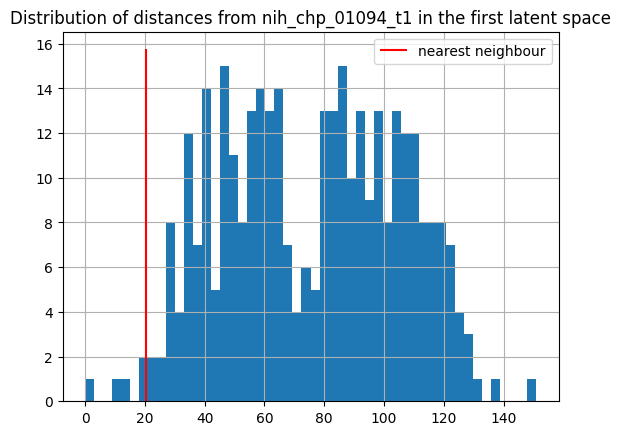

4.69208211143695%, 16-th element


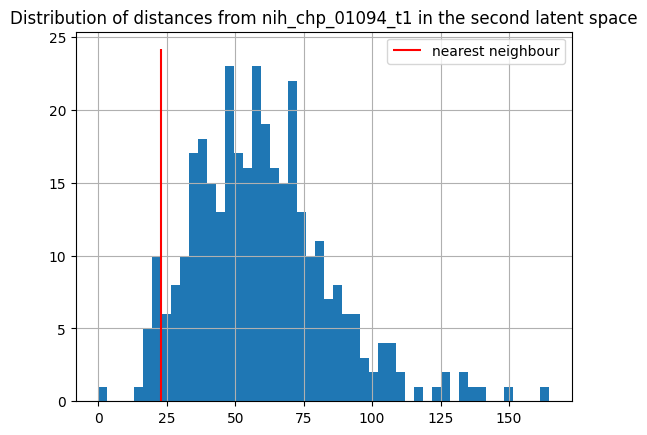

In [1317]:
# choose a random index
rand_idx = rd.choice(embeddings1.index)
print("rand_idx", rand_idx)

# get the nn of rand_idx for both latent spaces
nn1 = str(embeddings1.nn[rand_idx])
nn2 = str(embeddings2.nn[rand_idx])
print("nearest_neighbours:", nn1, nn2)
print()

# get the distances from rand_idx in the first latent space
dist2nn1 = dist_mat1[str(rand_idx)]
dist2nn1.hist(bins=50)
dist1 = dist2nn1[nn2]  # distance of nn2 in the first latent space
# calculate the percentile of dist(rand_idx, nn2) in the first latent space
percentile = percentileofscore(dist2nn1, dist1)
print(f'{percentile}%,', f'{int(percentile*len(dist2nn1)/100)}-th element')
# plot the distance distribution
ax = plt.gca()
ymin, ymax = ax.get_ylim()
plt.vlines(dist1, ymin=ymin, ymax=ymax, colors='red') # show position of nn in the other
                                                      # latent space
plt.title(f"Distribution of distances from {rand_idx} in the first latent space")
plt.legend(["nearest neighbour"])
plt.show()

# same thing for the second latent space (and nn1)
plt.figure()
dist2nn2 = dist_mat2[str(rand_idx)]
dist2nn2.hist(bins=50)
dist2 = dist2nn2[nn1]
percentile = percentileofscore(dist2nn2, dist2)
print(f'{percentile}%,', f'{int(percentile*len(dist2nn2)/100)}-th element')
ax = plt.gca()
ymin, ymax = ax.get_ylim()
plt.vlines(dist2, ymin=ymin, ymax=ymax, colors='red')
plt.title(f"Distribution of distances from {rand_idx} in the second latent space")
plt.legend(["nearest neighbour"])
plt.show()

### Average percentile of nn in the other latent space

In [1318]:
def get_percentile(distance_distrib_a, embeddings_b):
# distance_distrib_a is the distance distribution of idx in the latent space a, ie a column 
# (or line) of the associated dist_mat
    idx = distance_distrib_a.name
    nn = embeddings_b.nn[idx] ## nn is the nearest neighbour of idx in the latent space b
    
    dist_a = distance_distrib_a[str(nn)]
    percentile = percentileofscore(distance_distrib_a, dist_a)
    
    return percentile

In [1319]:
# function test


distance_distrib = dist_mat1['1-03HUBJO_t0']  # pick an element
print(get_percentile(distance_distrib, embeddings2))

dist_mat1.apply(get_percentile, axis=0, args=[embeddings2])

6.451612903225806


1-15LEHMI_t0                             3.225806
1-17COLMA_t0                             4.985337
1-18ROUCO_t0                             1.759531
1-40AYMJU_t0                             1.759531
2-02FERMA_t0                             2.052786
                                          ...    
sub-inhibition10_ses-pretraining_T1w    12.609971
sub-inhibition14_ses-pretraining_T1w     2.639296
sub-inhibition23_ses-pretraining_T1w     1.759531
sub-inhibition28_ses-pretraining_T1w     1.173021
sub-inhibition31_ses-pretraining_T1w     0.879765
Length: 341, dtype: float64

In [1320]:
def get_average_percentile(dist_mat1, dist_mat2, emb1, emb2):
# computes the average percentile a nn is sent to in the other latent space
    average_percentile_a = dist_mat1.apply(get_percentile, axis=0, args=[emb2]).mean()
    average_percentile_b = dist_mat2.apply(get_percentile, axis=0, args=[emb1]).mean()
    return (average_percentile_a + average_percentile_b) / 2

In [1321]:
average_percentile = get_average_percentile(dist_mat1, dist_mat2, embeddings1, embeddings2)
print(f'{average_percentile}%,', f'{average_percentile*550/100}-th element')

5.835003138947894%, 32.09251726421341-th element


### Position stats of nn in the other latent space

In [1322]:
def get_nn_stats(dist_mat1, dist_mat2, emb1, emb2):
    percentiles_a = dist_mat1.apply(get_percentile, axis=0, args=[emb2])
    percentiles_b = dist_mat2.apply(get_percentile, axis=0, args=[emb1])
    mean_a = percentiles_a.mean()
    mean_b = percentiles_b.mean()
    std_a = percentiles_a.std()
    std_b = percentiles_b.std()
    
    percentiles = pd.concat([percentiles_a, percentiles_b], axis=0, ignore_index=True)
    med = percentiles.median()
    first_quartile = percentiles.quantile(0.25)
    third_quartile = percentiles.quantile(0.75)

    nn_stats = {'mean': (mean_a + mean_b) / 2,
                'standard deviation': (std_a + std_b) / 2,
                'median': med,
                'first quartile': first_quartile,
                'third quartile': third_quartile}
    
    return nn_stats


In [1323]:
get_nn_stats(dist_mat1, dist_mat2, embeddings1, embeddings2)

{'mean': 5.835003138947894,
 'standard deviation': 7.340901146573126,
 'median': 2.932551319648094,
 'first quartile': 1.1730205278592376,
 'third quartile': 6.744868035190616}

### Histogram of position of nn in the other latent space


In [1324]:
def get_percentile_histograms(dist_mat1, dist_mat2, emb1, emb2, separate=False,
                              show_average=False, show_median=True, vlines_width=0.5,
                              save_path=None):
    
    percentiles_a = dist_mat1.apply(get_percentile, axis=0, args=[emb2])
    percentiles_b = dist_mat2.apply(get_percentile, axis=0, args=[emb1])

    if separate:
        # compute the histogram
        percentiles_a.hist(bins=range(101), color='red')
        legend = []
        ax = plt.gca()
        ymin, ymax = ax.get_ylim()
        if show_average:
            average = percentiles_a.mean()
            plt.vlines(average, ymin, ymax, color='black', 
                       linewidth=vlines_width)
            legend.append('Mean')
        if show_median:
            med = percentiles_a.median()
            plt.vlines(med,  ymin, ymax, color='blue', 
                       linewidth=vlines_width)
            legend.append('Median')
        plt.legend(legend)
        plt.title("Distribution of positions of nn2 in the latent space 1")

        plt.figure()
        percentiles_b.hist(bins=range(101), color='red')
        legend = []
        ax = plt.gca()
        ymin, ymax = ax.get_ylim()
        if show_average:
            average = percentiles_b.mean()
            plt.vlines(average, ymin, ymax, color='black', 
                       linewidth=vlines_width)
            legend.append('Mean')
        if show_median:
            med = percentiles_b.median()
            plt.vlines(med,  ymin, ymax, color='blue', 
                       linewidth=vlines_width)
            legend.append('Median')
        plt.legend(legend)
        plt.title("Distribution of positions of nn1 in the latent space 2")

    
    else:
        percentiles = pd.concat([percentiles_a, percentiles_b], axis=0, ignore_index=True)
        percentiles.hist(bins=range(101), color='red')
        legend = []
        ax = plt.gca()
        ymin, ymax = ax.get_ylim()
        if show_average:
            average = percentiles.mean()
            plt.vlines(average, ymin, ymax, color='black', 
                       linewidth=vlines_width)
            legend.append('Mean')
        if show_median:
            med = percentiles.median()
            plt.vlines(med,  ymin, ymax, color='blue', 
                       linewidth=vlines_width)
            legend.append('Median')
        plt.legend(legend)
        plt.title("Distribution of positions of nn in the other latent space")
        if save_path:
            plt.savefig(save_path)
    

09-15-52 11-40-43
{'mean': 5.835003138947894, 'standard deviation': 7.340901146573126, 'median': 2.932551319648094, 'first quartile': 1.1730205278592376, 'third quartile': 6.744868035190616}


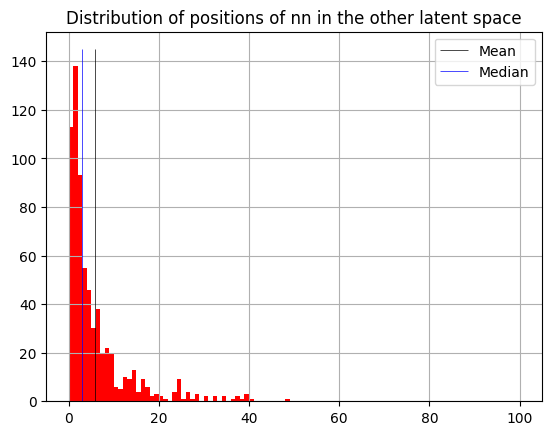

In [1325]:
#get_percentile_histograms(dist_mat1, dist_mat2, embeddings1, embeddings2, separate=True,
#show_average=True)

print(mod1, mod2)
fig_save_path = os.path.join(save_path, mod1+'_'+mod2+".png")
values_save_path = os.path.join(save_path, mod1+'_'+mod2+".txt")


plt.figure()
get_percentile_histograms(dist_mat1, dist_mat2, embeddings1, embeddings2, separate=False,
show_average=True, save_path=fig_save_path)

nn_stats = get_nn_stats(dist_mat1, dist_mat2, embeddings1, embeddings2)
print(nn_stats)


## save figure if wanted
if save_path:
    with open(values_save_path, 'w') as file:
        json.dump(nn_stats, file)

### Save the space nn distance for each model type and conditions

In [1328]:
# compute the mean score of all of them

"""saved_path = os.path.join(dir_path, "performance_comparisons/nn")

mod_conds = [folder for folder in os.listdir(saved_path) if os.path.isdir(os.path.join(saved_path,folder))]

nn_mean = np.zeros((len(mod_conds)//2, 2))

for folder in mod_conds:
    j = 0 if 'convnet' in folder else 1
    if "no" in folder:
        i = 2
    else:
        i = 0
    if '4' in folder:
        i += 1
    
    median_values = []
    for file in os.listdir(os.path.join(saved_path,folder)):
        if 'txt' in file:

            with open(os.path.join(saved_path, folder, file), 'r') as file_txt:
                file_content = json.load(file_txt)
            median_values.append(file_content['median'])

    nn_mean[i,j] = np.mean(median_values)

df = pd.DataFrame(nn_mean, columns=['convnet', 'densenet2'], index=['foldlabel_30', 'foldlabel_4', 'no_foldlabel_30', 'no_foldlabel_4'])
df.to_csv(saved_path+'/mean_median_nn.csv')
df"""

,convnet,densenet2
foldlabel_30,3.225806,8.929619
foldlabel_4,34.310850,34.692082
no_foldlabel_30,2.346041,2.580645
no_foldlabel_4,42.155425,29.120235


### Plot nn distance function of classifier perfomances

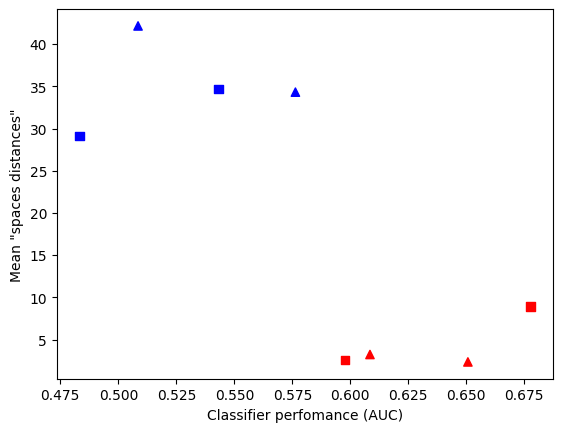

In [1329]:
# get the df (performance and nn distance)
"""saved_path = os.path.join(dir_path, "performance_comparisons/nn")
nn_df = pd.read_csv(saved_path+'/mean_median_nn.csv', index_col=0)

perf_df = pd.read_csv(dir_path+'/performance_comparisons/performance_comparison_5000.csv', index_col=0)


shapes = ['^', 's'] # each model type has a shape

# plot
for i,model_type in enumerate(nn_df.columns):
    X = perf_df[model_type].values
    Y = nn_df[model_type].values
    colors = ['r', 'b', 'r', 'b']

    plt.scatter(X, Y, color=colors, marker=shapes[i])


plt.xlabel("Classifier perfomance (AUC)")
plt.ylabel('Mean "spaces distances"')
plt.show()"""

# C'est le cancer pour faire une légende bien, alors : triangle == convnet, square == densenet2, red == dim 30, blue == dim 4

In [1330]:
perf_df

,convnet,densenet2,pca
foldlabel_30,0.608461,0.677587,0.593625
foldlabel_4,0.576327,0.543187,0.538784
no_foldlabel_30,0.650671,0.597630,0.593625
no_foldlabel_4,0.508503,0.483250,0.538784
